# Investigating number of parameters vs. realizations in user runs

The goal of this small notebook is to gain some intuition about the configurations that users actually run ERT with. 
- How many parameters do they typically have?
- What is the ratio between the number of parameters and realzations typically?
- How many users do history matching?
- How many users use fields and surfaces?

> Query used to export `query_data.csv` 

```kusto
let ops_with_d2p = AppTraces
| where Message has "Content of the config_dict"
| where Message has "DESIGN2PARAMS"
| distinct OperationId;

AppTraces
| where not(tolower(tostring(Properties.MACHINE_USER)) == "true")
| where OperationId !in (ops_with_d2p)
| where Message startswith "Experiment summary:"
| extend Runmodel     = extract("Runmodel: (.+)", 1, Message),
         Realizations = toint(extract("Realizations: (.+)", 1, Message)),
         Parameters   = toint(extract("Parameters: (.+)", 1, Message)),
         Observations = toint(extract("Observations: (.+)", 1, Message))
| where not(tolower(tostring(Runmodel)) contains "test_run")
| where Parameters > 0
```

### Assumptions and background

- The runs are gathered from the last 21 days on the 04-02-2026. The logging was added on the 14-01-2026, so we were not able to fetch data before this point.
- All runs using DESIGN2PARAMS were excluded, because we were unable to log the number of parameters for these runs. 1444 out of 1575 were not using DESIGN2PARAMS.

## Imports

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("query_data.csv")

### General statistics about parameters, realizations and observations

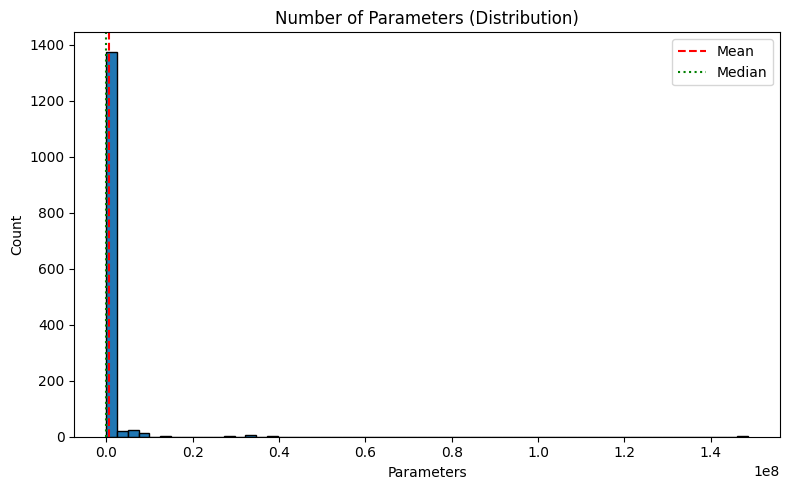

count    1.444000e+03
mean     6.735563e+05
std      6.191686e+06
min      1.000000e+00
10%      1.000000e+01
50%      1.440000e+02
90%      1.010000e+03
max      1.486511e+08
Name: Parameters, dtype: float64

In [40]:
params = df["Parameters"].dropna()
raw_param_stats = params.describe(percentiles=[0.1, 0.5, 0.9])
param_stats = raw_param_stats.round(0)
param_stats[["mean", "std"]] = raw_param_stats[["mean", "std"]].round(2)

plt.figure(figsize=(8, 5))
plt.hist(params, bins=60, edgecolor="black")
plt.axvline(params.mean(), color="red", linestyle="--", label="Mean")
plt.axvline(params.median(), color="green", linestyle=":", label="Median")
plt.title("Number of Parameters (Distribution)")
plt.xlabel("Parameters")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

param_stats

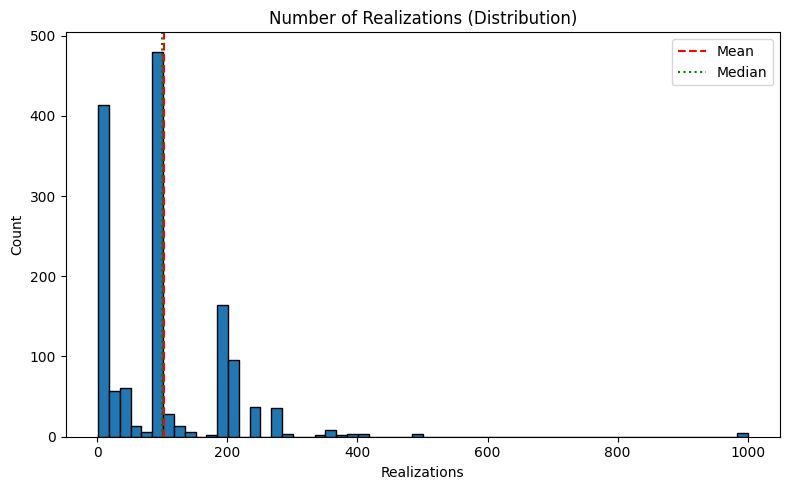

count    1444.00
mean      102.41
std       102.70
min         1.00
10%         2.00
50%       100.00
90%       210.00
max      1000.00
Name: Realizations, dtype: float64

In [39]:
realizations = df["Realizations"].dropna()
raw_realization_stats = realizations.describe(percentiles=[0.1, 0.5, 0.9])
realization_stats = raw_realization_stats.round(0)
realization_stats[["mean", "std"]] = raw_realization_stats[["mean", "std"]].round(2)

plt.figure(figsize=(8, 5))
plt.hist(realizations, bins=60, edgecolor="black")
plt.axvline(realizations.mean(), color="red", linestyle="--", label="Mean")
plt.axvline(realizations.median(), color="green", linestyle=":", label="Median")
plt.title("Number of Realizations (Distribution)")
plt.xlabel("Realizations")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

realization_stats

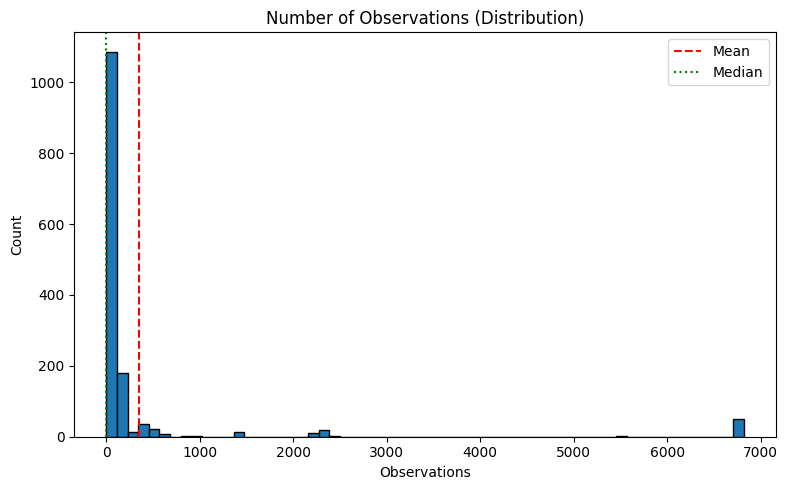

count    1444.00
mean      353.67
std      1287.70
min         0.00
10%         0.00
50%         0.00
90%       369.00
max      6819.00
Name: Observations, dtype: float64

In [41]:
observations = df["Observations"].dropna()
raw_observation_stats = observations.describe(percentiles=[0.1, 0.5, 0.9])
observation_stats = raw_observation_stats.round(0)
observation_stats[["mean", "std"]] = raw_observation_stats[["mean", "std"]].round(2)

plt.figure(figsize=(8, 5))
plt.hist(observations, bins=60, edgecolor="black")
plt.axvline(observations.mean(), color="red", linestyle="--", label="Mean")
plt.axvline(observations.median(), color="green", linestyle=":", label="Median")
plt.title("Number of Observations (Distribution)")
plt.xlabel("Observations")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

observation_stats

## Plot parameters/realizations ratio
Visualize the ratio of parameters to realizations.

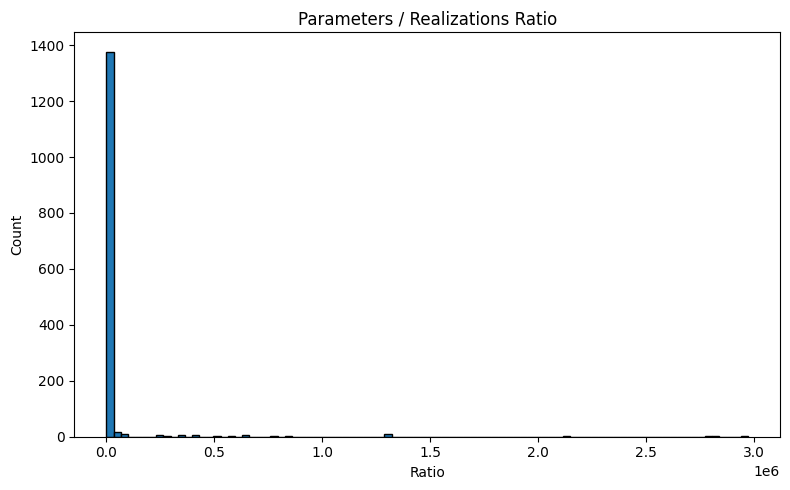

In [30]:
df["Realizations"] = pd.to_numeric(df["Realizations"], errors="coerce")
df["Parameters"] = pd.to_numeric(df["Parameters"], errors="coerce")

# Compute ratio and filter invalid entries
ratio = (df["Parameters"] / df["Realizations"]).replace(
    [float("inf"), -float("inf")], pd.NA
)
ratio = ratio.dropna()

plt.figure(figsize=(8, 5))
plt.hist(ratio, bins=90, edgecolor="black")
plt.title("Parameters / Realizations Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Ratio histogram for 1–10

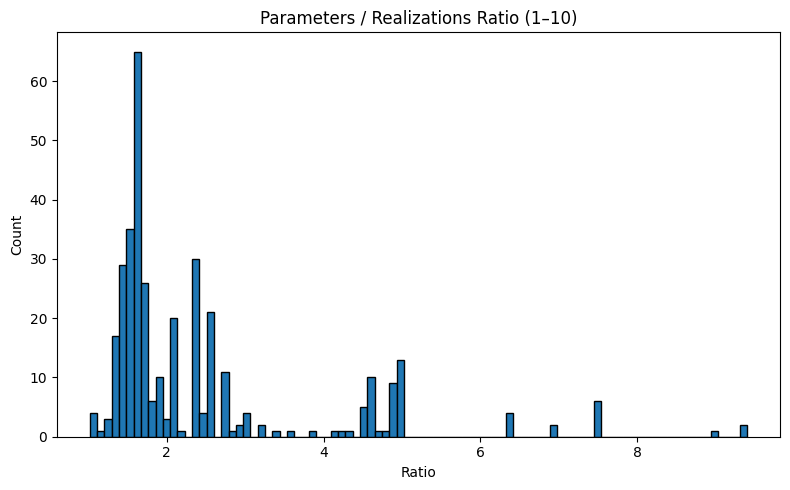

In [31]:
# Histogram of ratios between 1 and 10
ratio_1_10 = ratio[(ratio >= 1) & (ratio <= 10)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_1_10, bins=90, edgecolor="black")
plt.title("Parameters / Realizations Ratio (1–10)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Ratio histogram for 0–1
These are the runs where there are more realizations than parameters.

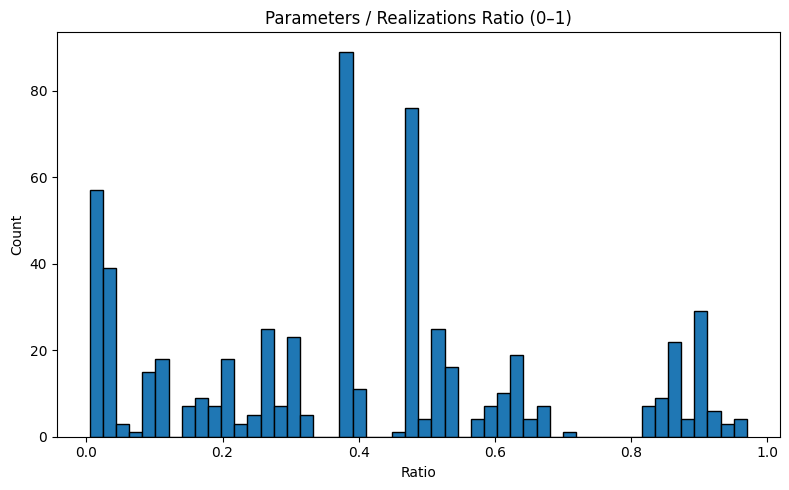

In [32]:
# Histogram of ratios between 0 and 1
ratio_0_1 = ratio[(ratio >= 0) & (ratio <= 1)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_0_1, bins=50, edgecolor="black")
plt.title("Parameters / Realizations Ratio (0–1)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Ratio distribution summary

In [33]:
# Ratio distribution statistics
total = ratio.notna().sum()

count_0_1 = ((ratio >= 0) & (ratio <= 1)).sum()
count_1_10 = ((ratio > 1) & (ratio <= 10)).sum()
count_above_10 = (ratio > 10).sum()

stats = pd.DataFrame(
    {
        "ratio": ["0–1", "1–10", ">10"],
        "count": [count_0_1, count_1_10, count_above_10],
        "percent": [
            count_0_1 / total * 100,
            count_1_10 / total * 100,
            count_above_10 / total * 100,
        ],
    }
)

stats

,ratio,count,percent
0,0–1,600,41.551247
1,1–10,355,24.584488
2,>10,489,33.864266


## Scatterplots across metrics
Visualize relationships between realizations, parameters, and observations (excluding zero observations).

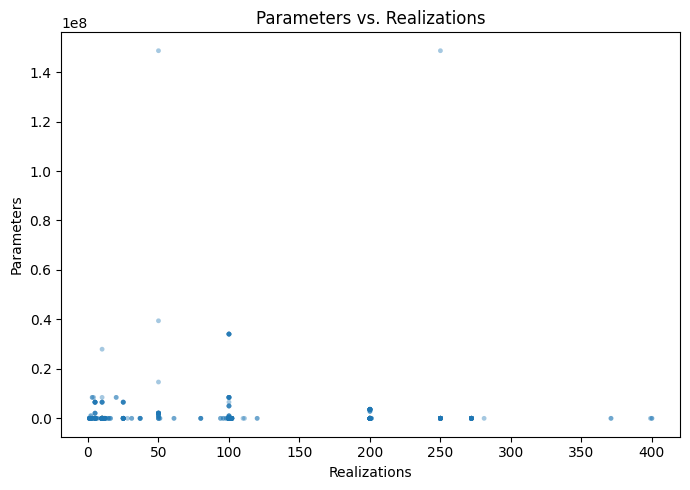

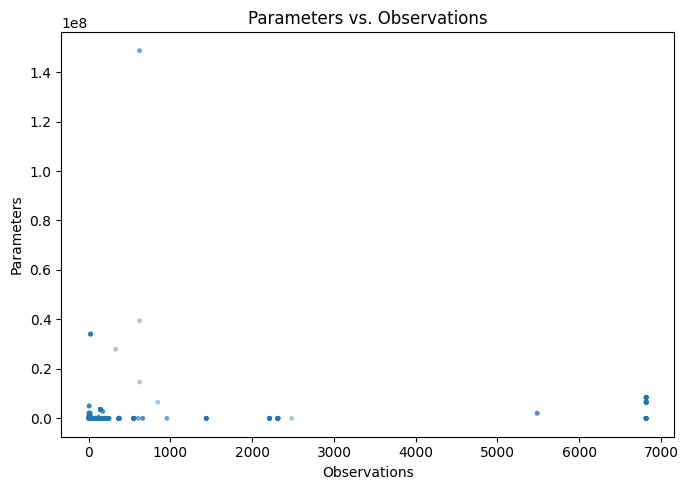

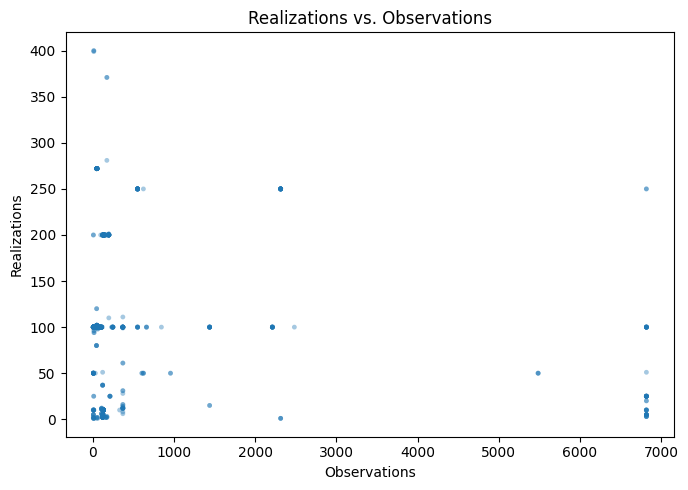

In [34]:
# Scatterplots for relationships between metrics
scatter_df = df.copy()
scatter_df["Realizations"] = pd.to_numeric(scatter_df["Realizations"], errors="coerce")
scatter_df["Parameters"] = pd.to_numeric(scatter_df["Parameters"], errors="coerce")
scatter_df["Observations"] = pd.to_numeric(scatter_df["Observations"], errors="coerce")
scatter_df = scatter_df.dropna(subset=["Realizations", "Parameters", "Observations"])
scatter_df = scatter_df[scatter_df["Observations"] > 0]

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_df["Realizations"],
    scatter_df["Parameters"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Parameters vs. Realizations")
plt.xlabel("Realizations")
plt.ylabel("Parameters")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_df["Observations"],
    scatter_df["Parameters"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Parameters vs. Observations")
plt.xlabel("Observations")
plt.ylabel("Parameters")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_df["Observations"],
    scatter_df["Realizations"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Realizations vs. Observations")
plt.xlabel("Observations")
plt.ylabel("Realizations")
plt.tight_layout()
plt.show()

## Scatterplots trimmed to 90th percentiles
Repeat scatterplots after trimming outliers to the 90th percentile.

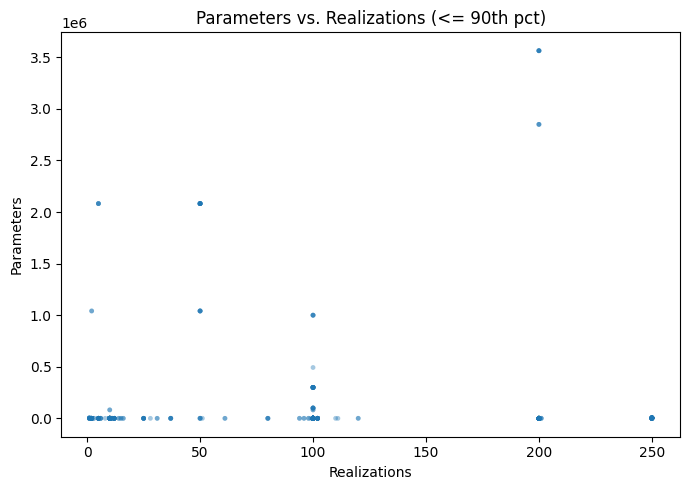

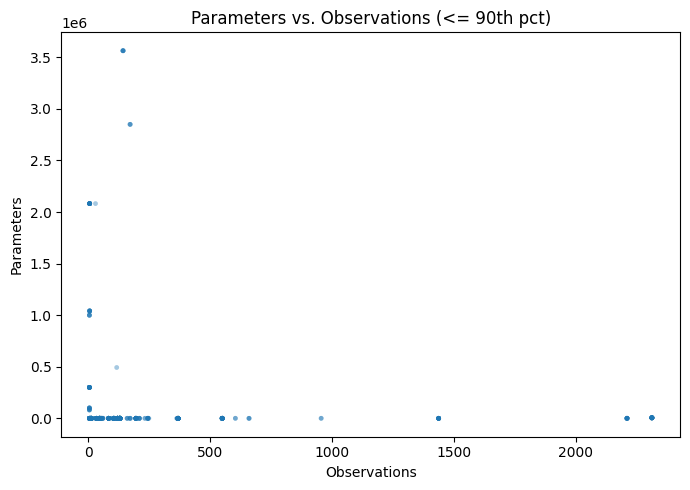

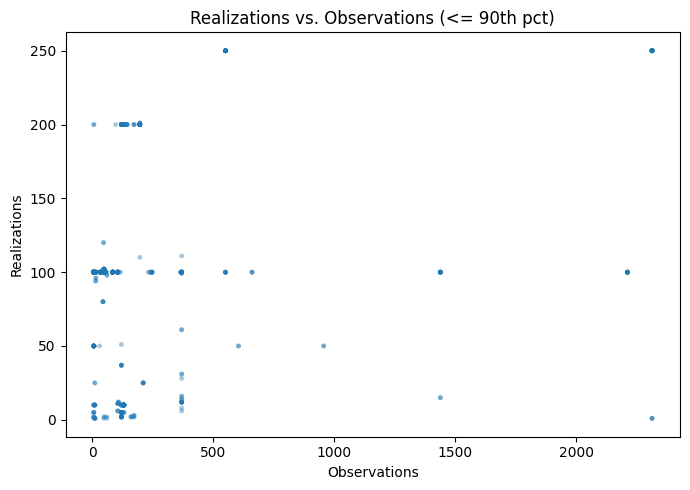

In [35]:
# Scatterplots within the 90th percentiles (trim outliers)
q_real = scatter_df["Realizations"].quantile(0.9)
q_param = scatter_df["Parameters"].quantile(0.9)
q_obs = scatter_df["Observations"].quantile(0.9)

scatter_q90 = scatter_df[
    (scatter_df["Realizations"] <= q_real)
    & (scatter_df["Parameters"] <= q_param)
    & (scatter_df["Observations"] <= q_obs)
    & (scatter_df["Observations"] > 0)
].copy()

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_q90["Realizations"],
    scatter_q90["Parameters"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Parameters vs. Realizations (<= 90th pct)")
plt.xlabel("Realizations")
plt.ylabel("Parameters")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_q90["Observations"],
    scatter_q90["Parameters"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Parameters vs. Observations (<= 90th pct)")
plt.xlabel("Observations")
plt.ylabel("Parameters")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(
    scatter_q90["Observations"],
    scatter_q90["Realizations"],
    s=12,
    alpha=0.4,
    edgecolors="none",
)
plt.title("Realizations vs. Observations (<= 90th pct)")
plt.xlabel("Observations")
plt.ylabel("Realizations")
plt.tight_layout()
plt.show()

## Plot parameters/observations ratio
Compute and visualize the ratio of parameters to observations.

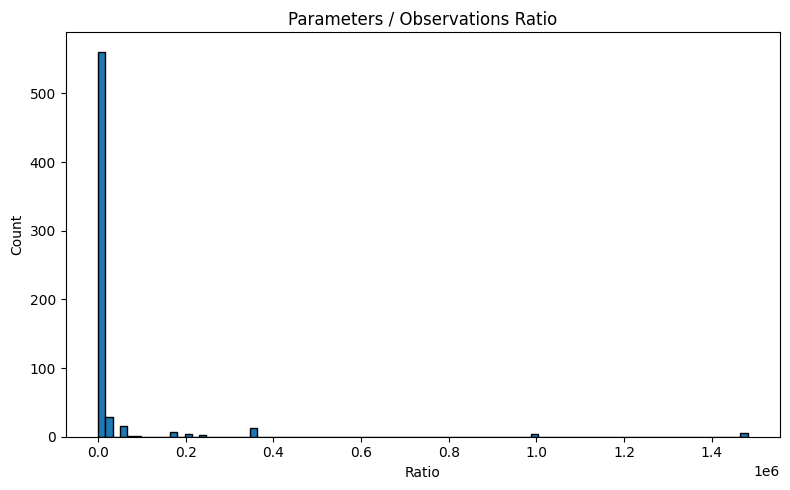

In [36]:
df["Observations"] = pd.to_numeric(df["Observations"], errors="coerce")
ratio = (df["Parameters"] / df["Observations"]).replace(
    [float("inf"), -float("inf")], pd.NA
)
ratio = ratio.dropna()

plt.figure(figsize=(8, 5))
plt.hist(ratio, bins=90, edgecolor="black")
plt.title("Parameters / Observations Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Parameters/observations ratio (0–1)
The runs where there are more observations than parameters.

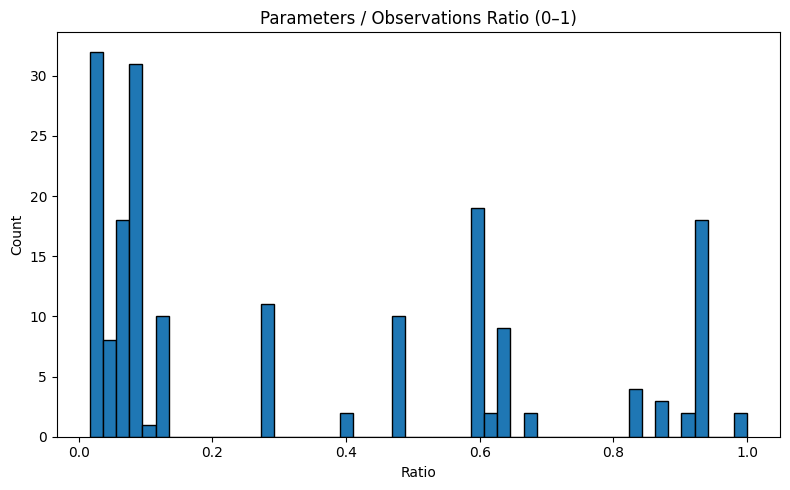

In [37]:
# Histogram of ratios between 0 and 1
ratio_0_1 = ratio[(ratio >= 0) & (ratio <= 1)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_0_1, bins=50, edgecolor="black")
plt.title("Parameters / Observations Ratio (0–1)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Parameters/observations ratio summary


In [38]:
# Ratio distribution statistics
total = ratio.notna().sum()

count_0_1 = ((ratio >= 0) & (ratio <= 1)).sum()
count_1_10 = ((ratio > 1) & (ratio <= 10)).sum()
count_above_10 = (ratio > 10).sum()

stats = pd.DataFrame(
    {
        "ratio": ["0–1", "1–10", ">10"],
        "count": [count_0_1, count_1_10, count_above_10],
        "percent": [
            count_0_1 / total * 100,
            count_1_10 / total * 100,
            count_above_10 / total * 100,
        ],
    }
)

stats

,ratio,count,percent
0,0–1,184,28.660436
1,1–10,294,45.794393
2,>10,164,25.545171
